<a href="https://colab.research.google.com/github/kislay960/Describe-an-image/blob/main/Describe%20Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DECRIBE AN IMAGE

PREREQUISITES : Multi Layer Perceptron, Convolutional Neural Networks, Recurrent Neural Network, Word Embeddings, Transfer Learning

In [32]:
#importing all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

###Data Preparation

In [33]:
#Function to read text in files
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [34]:
captions  = readTextFile("/content/drive/MyDrive/image_caption/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]

In [35]:
len(captions)

40460

In [36]:
# Dictionary to Map each Image with the list of 5 captions it has
descriptions = {}

for x in captions:

    first,second = x.split('\t')
    img_name = str(first.split('.')[0])

    #if the image id is not present in the dictionary, add it to dictionary
    if img_name not in descriptions:
        descriptions[img_name] = []
    
    #add the caption in the dictionary
    descriptions[img_name].append(second)

In [37]:
#Reading captions for a sample image
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

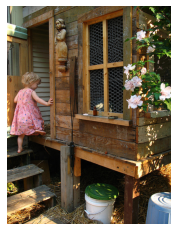

In [38]:
#Displaying that sample image
IMG_PATH = "/content/drive/MyDrive/image_caption/Flickr_Data/Flickr_Data/Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

###Data Cleaning

In [39]:
#Function to clean sentences to reduce vocab size and prevent overfitting
def clean_text(sentence):

    #convert everything to lowercase
    sentence = sentence.lower()

    #remove special characters and numbers
    sentence = re.sub("[^a-z]+"," ",sentence)
    
    #remove insignificant words with length one.
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s)>1]
    sentence = ' '.join(sentence)

    return sentence

In [40]:
# Clean all Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [41]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [42]:
# Write the data to text file
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

###Creating Vocabulary

In [43]:
descriptions = None
with open("/content/descriptions_1.txt",'r') as f:
    descriptions= f.read()

In [44]:
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)
print(type(descriptions))

<class 'dict'>


In [45]:
# Vocab
vocab = set()

for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [46]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Total Words 373837


In [47]:
#This means we have total 373837 words and 8424 unique words.
# We will Filter Words from the Vocab according to certain threshold frequncy
from collections import Counter

freq_cnt = Counter(total_words)

print(len(freq_cnt.keys()))

8424


In [48]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [49]:
print(len(total_words))

1845


###Preparing training and test data

In [50]:
#reading .txt files
train_file_data = readTextFile('/content/drive/MyDrive/image_caption/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt')
test_file_data = readTextFile('/content/drive/MyDrive/image_caption/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt')

In [51]:
#removing .jpg from each photos name
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [52]:
#printing first five training image names
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [53]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [54]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

###Transfer Learning Step 1 - Image Feature Extraction

In [55]:
#resnet is not a sequential model. It has skip connections, therefore the fourth column is present in summary
#skip connection allows the network to learn without vanishing gradients.
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [56]:
#We will use this GAP Layer to extract features for our model
model.layers[-2]

In [57]:
#making our new model
model_new = Model(model.input,model.layers[-2].output)

In [58]:
#Function to preprocess our images
def preprocess_img(img):
    
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    
    # Normalisation
    img = preprocess_input(img)
    
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


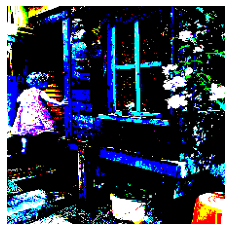

In [59]:
#Displaying our earlier image after preprocessing it.
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [60]:
#step1 - preprocess image
#step2 - pass the preprocessed image through the resnet-50 conv base
#after feature extraction we get a 2048 dimensional vector. This process is encoding
def encode_image(img):
    
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    
    return feature_vector

In [61]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg").shape

(2048,)

In [62]:
#Encoding all the images
start = time()

encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):

    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)

    if ix%100==0:
        print("Train Encoding in Progress. Files encoded : %d "%ix)
      
end = time()
print("Total Time Taken :",end-start)

!mkdir saved

# Store everything to the disk
# Storing everything so we dont have to encode again.
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

Train Encoding in Progress. Files encoded : 0 
Train Encoding in Progress. Files encoded : 100 
Train Encoding in Progress. Files encoded : 200 
Train Encoding in Progress. Files encoded : 300 
Train Encoding in Progress. Files encoded : 400 
Train Encoding in Progress. Files encoded : 500 
Train Encoding in Progress. Files encoded : 600 
Train Encoding in Progress. Files encoded : 700 
Train Encoding in Progress. Files encoded : 800 
Train Encoding in Progress. Files encoded : 900 
Train Encoding in Progress. Files encoded : 1000 
Train Encoding in Progress. Files encoded : 1100 
Train Encoding in Progress. Files encoded : 1200 
Train Encoding in Progress. Files encoded : 1300 
Train Encoding in Progress. Files encoded : 1400 
Train Encoding in Progress. Files encoded : 1500 
Train Encoding in Progress. Files encoded : 1600 
Train Encoding in Progress. Files encoded : 1700 
Train Encoding in Progress. Files encoded : 1800 
Train Encoding in Progress. Files encoded : 1900 
Train Encodi

In [63]:
start = time()

encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):

    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)

    if ix%100==0:
        print("Test Encoding in Progress. Files encoded : %d "%ix)
      
end = time()
print("Total Time Taken :",end-start)

# Store everything to the disk 
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

Test Encoding in Progress. Files encoded : 0 
Test Encoding in Progress. Files encoded : 100 
Test Encoding in Progress. Files encoded : 200 
Test Encoding in Progress. Files encoded : 300 
Test Encoding in Progress. Files encoded : 400 
Test Encoding in Progress. Files encoded : 500 
Test Encoding in Progress. Files encoded : 600 
Test Encoding in Progress. Files encoded : 700 
Test Encoding in Progress. Files encoded : 800 
Test Encoding in Progress. Files encoded : 900 
Total Time Taken : 587.4212744235992


###Data Preprocessing - Captions

In [64]:
#Two dictionaries to hold key value pairs of word and index
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):

    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [65]:
print(word_to_idx["dog"])
print(idx_to_word[6])
print(len(idx_to_word))

6
dog
1845


In [66]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1 # +1 is for zero index
print("Vocab Size",vocab_size)

Vocab Size 1848


In [67]:
#Maximum length caption
max_len = 0 

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


###Data Loader (Generator)

In [68]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    
    X1,X2, y = [],[],[]
    n = 0
    
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield ([np.array(X1),np.array(X2)],np.array(y))
                    X1,X2,y = [],[],[]
                    n = 0

###Word Embeddings

In [69]:
#Using Glove 6B 50D for word embeddings
f = open('/content/drive/MyDrive/glove.6B.50d.txt',encoding='utf8')

In [70]:
#Dictionary for glove vector for every word
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [71]:
f.close()

In [72]:
embedding_index['dog']

array([ 0.11008  , -0.38781  , -0.57615  , -0.27714  ,  0.70521  ,
        0.53994  , -1.0786   , -0.40146  ,  1.1504   , -0.5678   ,
        0.0038977,  0.52878  ,  0.64561  ,  0.47262  ,  0.48549  ,
       -0.18407  ,  0.1801   ,  0.91397  , -1.1979   , -0.5778   ,
       -0.37985  ,  0.33606  ,  0.772    ,  0.75555  ,  0.45506  ,
       -1.7671   , -1.0503   ,  0.42566  ,  0.41893  , -0.68327  ,
        1.5673   ,  0.27685  , -0.61708  ,  0.64638  , -0.076996 ,
        0.37118  ,  0.1308   , -0.45137  ,  0.25398  , -0.74392  ,
       -0.086199 ,  0.24068  , -0.64819  ,  0.83549  ,  1.2502   ,
       -0.51379  ,  0.04224  , -0.88118  ,  0.7158   ,  0.38519  ])

In [73]:
#Creating embedding matrix of size (Vocab_size X 50)
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [74]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

###Model Architecture

In [75]:
#Image Input - Input from resnet 50 GAP Layer
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [76]:
#Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [77]:
#Combine the two inputs and feed it to the model
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [78]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_4[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_3[0][0]                    
_______________________________________________________________________________________

In [79]:
#Pre-initialize the Embedding Layer. We have already created it.
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [80]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

###Training our model

In [81]:
encoded_train_features = open('/content/saved/encoded_train_features.pkl','rb')
encoding_train = pickle.load(encoded_train_features)

In [82]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [83]:
!mkdir model_weights

In [84]:
#Change the runtime type. Choose the hardware accelerator as GPU for faster results
for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps)
    model.save('/content/model_weights/model_'+str(i)+'.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
2000/2000 [==============================] - 25s 13ms/step - loss: 2.5576


In [86]:
epochs = 10
batch_size = 6
steps = len(train_descriptions)//batch_size

In [87]:
for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps)
    model.save('/content/model_weights/model_'+str(i+20)+'.h5')

1000/1000 [==============================] - 19s 19ms/step - loss: 2.3989


In [88]:
model = load_model('./model_weights/model_29.h5')

###Prediction

In [89]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [92]:
with open("/content/saved/encoded_test_features.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [152]:
# Pick Some Random Image and See Results
def see_results():
    plt.style.use("seaborn")
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))

    i = plt.imread("/content/drive/MyDrive/image_caption/Flickr_Data/Flickr_Data/Images/"+img_name+".jpg")

    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    return caption

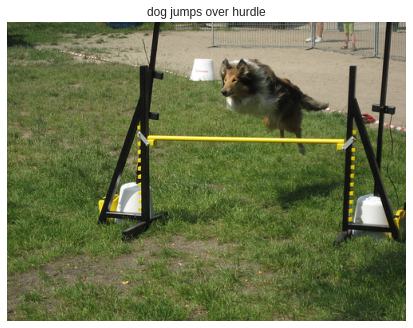

In [105]:
see_results()

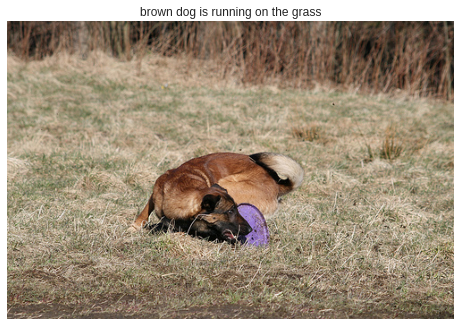

In [99]:
see_results()

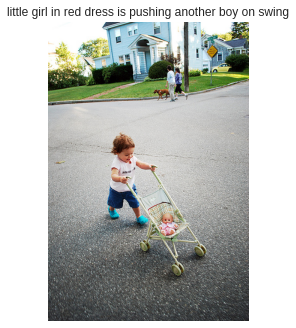

In [101]:
see_results()

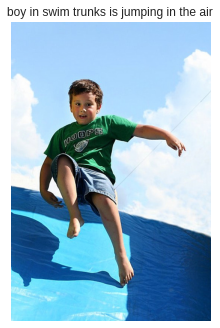

In [102]:
see_results()

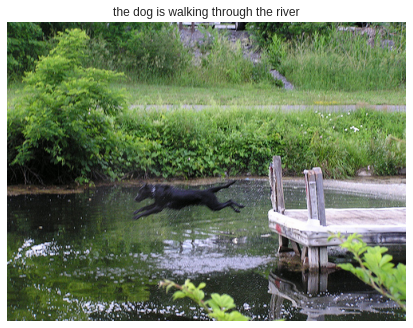

In [110]:
see_results()

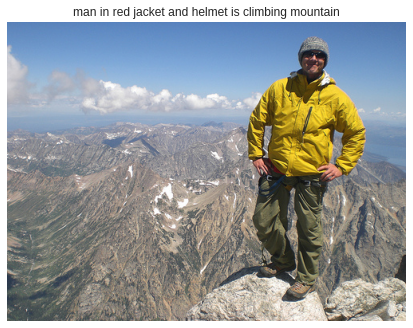

In [114]:
see_results()

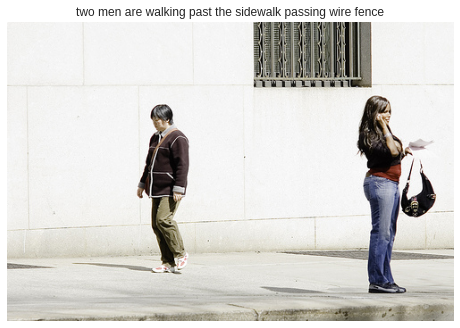

In [120]:
see_results()

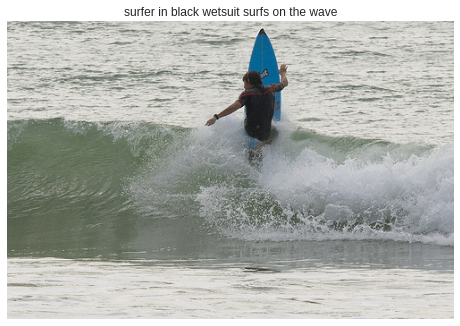

In [123]:
see_results()

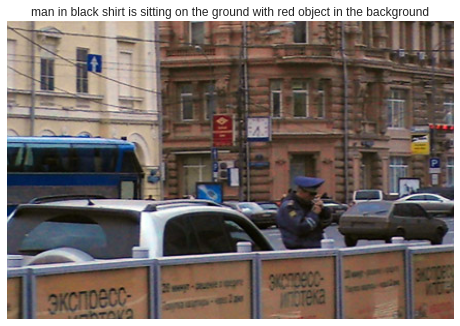

In [125]:
see_results()

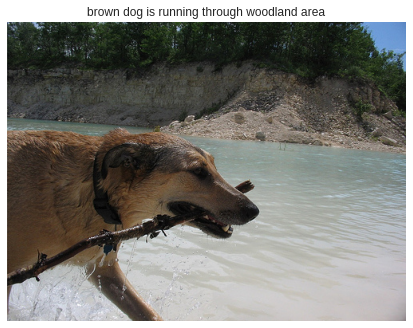

In [131]:
see_results()

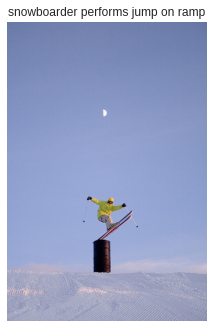

In [148]:
see_results()

You can also convert the caption to speech to help blind people.

In [142]:
from gtts import gTTS #Import Google Text to Speech
from IPython.display import Audio #Import Audio method from IPython's Display Class

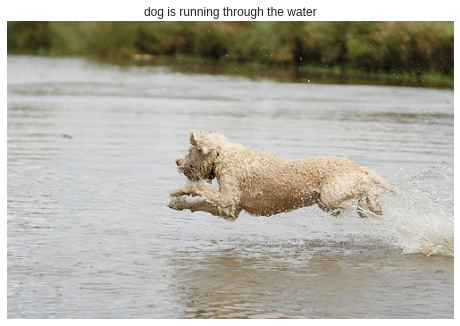

In [158]:
cap = see_results()
tts = gTTS(cap) #Provide the string to convert to speech
tts.save('1.wav') #save the string converted to speech as a .wav file
sound_file = '1.wav'
Audio(sound_file, autoplay=True)

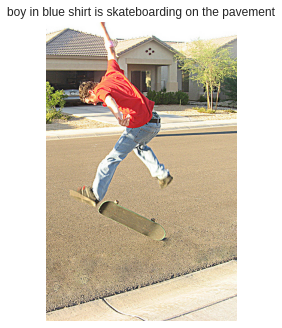

In [160]:
cap = see_results()
tts = gTTS(cap) #Provide the string to convert to speech
tts.save('1.wav') #save the string converted to speech as a .wav file
sound_file = '1.wav'
Audio(sound_file, autoplay=True)

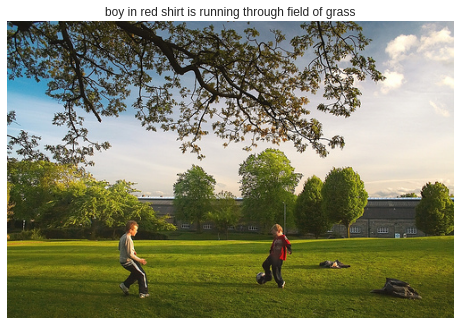

In [161]:
cap = see_results()
tts = gTTS(cap) #Provide the string to convert to speech
tts.save('1.wav') #save the string converted to speech as a .wav file
sound_file = '1.wav'
Audio(sound_file, autoplay=True)

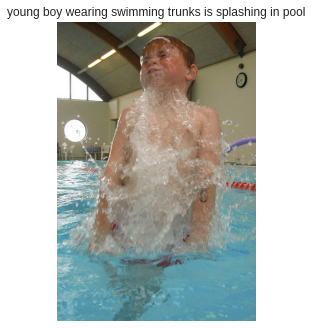

In [162]:
cap = see_results()
tts = gTTS(cap) #Provide the string to convert to speech
tts.save('1.wav') #save the string converted to speech as a .wav file
sound_file = '1.wav'
Audio(sound_file, autoplay=True)

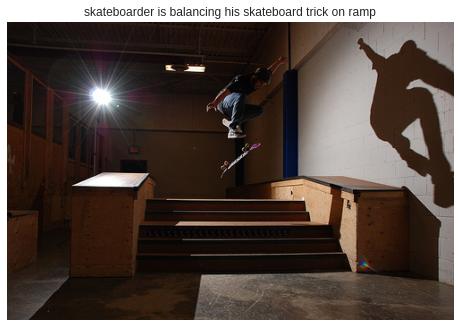

In [163]:
cap = see_results()
tts = gTTS(cap) #Provide the string to convert to speech
tts.save('1.wav') #save the string converted to speech as a .wav file
sound_file = '1.wav'
Audio(sound_file, autoplay=True)

Reference : https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8